In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- Preprocessing --
from sklearn.model_selection import GroupShuffleSplit # <-- THE CORRECT SPLITTER
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# -- Baseline Models --
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# -- Evaluation --
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Set plot style
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("All libraries for Phase 2 imported.")

All libraries for Phase 2 imported.


In [2]:
# --- Load our Master "v1" dataset ---
file_path = '../data/master_training_data.csv'
df_master = pd.read_csv(file_path)

print(f"Loaded master data with shape: {df_master.shape}")

# --- Define Target (y) ---
y = df_master['PURCHASE_FLG']

# --- Define Features (X) for v1 Baseline ---
# We will ONLY use the simple customer segment features
X = df_master[['AGE', 'SEX_ID']]

# --- Define Groups (g) for Splitting ---
# This is the key to our leak-free split
g = df_master['USER_ID_hash']

print("\n--- Target (y) ---")
print(y.value_counts())

print("\n--- Features (X) for v1 model ---")
display(X.head())

print("\n--- Groups (g) for v1 model ---")
display(g.head())

Loaded master data with shape: (2517206, 37)

--- Target (y) ---
PURCHASE_FLG
0    2394817
1     122389
Name: count, dtype: int64

--- Features (X) for v1 model ---


,AGE,SEX_ID
0,25,f
1,25,f
2,25,f
3,25,f
4,25,f



--- Groups (g) for v1 model ---


0    d9dca3cb44bab12ba313eaa681f663eb
1    d9dca3cb44bab12ba313eaa681f663eb
2    d9dca3cb44bab12ba313eaa681f663eb
3    d9dca3cb44bab12ba313eaa681f663eb
4    d9dca3cb44bab12ba313eaa681f663eb
Name: USER_ID_hash, dtype: object

In [3]:
# --- Create the GroupShuffleSplit ---
# We'll do one split (n_splits=1) with 20% of the groups(users) in the test set.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for our train and test sets
# gss.split returns the indices of the rows
train_idx, test_idx = next(gss.split(X, y, groups=g))

# Create our dataframes using these indices
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"--- Leak-Free Split Created ---")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- Sanity Check ---
# Check if any user from the training set is also in the test set
train_users = g.iloc[train_idx].unique()
test_users = g.iloc[test_idx].unique()
leakage = np.intersect1d(train_users, test_users)

if len(leakage) == 0:
    print(f"\nSUCCESS: No user leakage detected. Train/Test sets are clean.")
else:
    print(f"\nERROR: {len(leakage)} users are in BOTH train and test sets. Leakage detected!")

--- Leak-Free Split Created ---
Total samples: 2517206
Training samples: 2031838
Testing samples: 485368

SUCCESS: No user leakage detected. Train/Test sets are clean.


In [4]:
# --- Build the data Preprocessing Pipeline ---

# 1. Define lists of column names by their type
numeric_features = ['AGE']
categorical_features = ['SEX_ID']

# 2. Create the transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Create the 'preprocessor'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("--- 'v1' Preprocessing pipeline built successfully ---")
display(preprocessor)

--- 'v1' Preprocessing pipeline built successfully ---


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [5]:
# --- Calculate Class Weights ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Calculated class weights to handle imbalance:")
print(f"The model will treat class 0 ('No') with weight: {class_weight_dict[0]:.2f}")
print(f"The model will treat class 1 ('Yes') with weight: {class_weight_dict[1]:.2f}")

Calculated class weights to handle imbalance:
The model will treat class 0 ('No') with weight: 0.53
The model will treat class 1 ('Yes') with weight: 10.35


In [6]:
# --- Dictionary to store results ---
model_results = {}

# --- Model 1: Logistic Regression ---
print("\n=========================================")
print("Training Logistic Regression (v1)...")

log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, class_weight=class_weight_dict))
])
log_reg_pipeline.fit(X_train, y_train)
y_pred_log_reg = log_reg_pipeline.predict(X_test)

model_results['Logistic Regression (v1)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_log_reg),
    'F1-Score (Yes)': f1_score(y_test, y_pred_log_reg, pos_label=1)
}
print(f"--- Results for Logistic Regression (v1) ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['No (0)', 'Yes (1)']))

# --- Model 2: Decision Tree ---
print("\n=========================================")
print("Training Decision Tree (v1)...")

tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, max_depth=10, class_weight=class_weight_dict))
])
tree_pipeline.fit(X_train, y_train)
y_pred_tree = tree_pipeline.predict(X_test)

model_results['Decision Tree (v1)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_tree),
    'F1-Score (Yes)': f1_score(y_test, y_pred_tree, pos_label=1)
}
print(f"--- Results for Decision Tree (v1) ---")
print(classification_report(y_test, y_pred_tree, target_names=['No (0)', 'Yes (1)']))


Training Logistic Regression (v1)...
--- Results for Logistic Regression (v1) ---
              precision    recall  f1-score   support

      No (0)       0.95      0.55      0.69    461154
     Yes (1)       0.05      0.47      0.09     24214

    accuracy                           0.54    485368
   macro avg       0.50      0.51      0.39    485368
weighted avg       0.91      0.54      0.66    485368


Training Decision Tree (v1)...
--- Results for Decision Tree (v1) ---
              precision    recall  f1-score   support

      No (0)       0.95      0.54      0.69    461154
     Yes (1)       0.05      0.46      0.09     24214

    accuracy                           0.53    485368
   macro avg       0.50      0.50      0.39    485368
weighted avg       0.90      0.53      0.66    485368




--- v1 Baseline Model Scores (Leak-Free) ---


,Accuracy,F1-Score (Yes)
Logistic Regression (v1),0.541350,0.092061
Decision Tree (v1),0.534444,0.089221


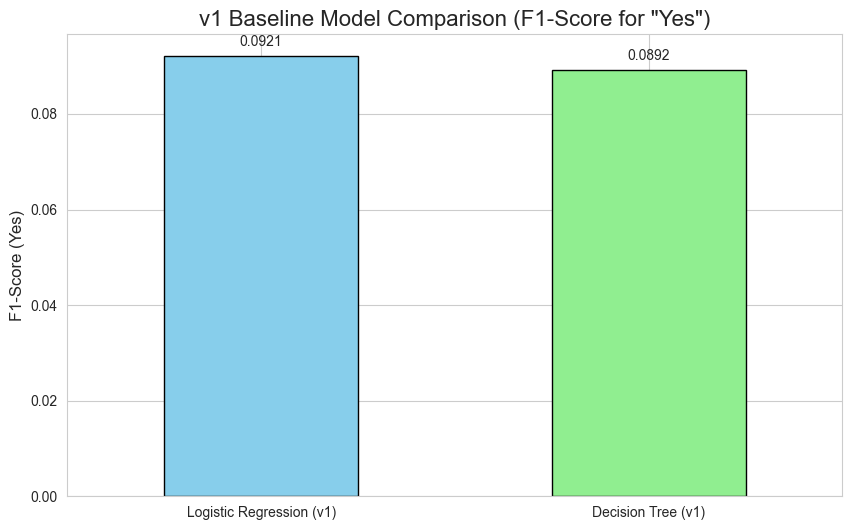


This is our true, leak-free 'score to beat'.
Our 'v2' models in the next notebook will try to dramatically improve this F1-Score.


In [7]:
# --- Visualize Model Comparison ---

results_df = pd.DataFrame(model_results).T

print("\n--- v1 Baseline Model Scores (Leak-Free) ---")
display(results_df)

# --- Plot the F1-Score (for 'Yes') ---
plt.figure(figsize=(10, 6))
ax = results_df['F1-Score (Yes)'].plot(
    kind='bar',
    color=['skyblue', 'lightgreen'],
    edgecolor='black'
)
ax.set_title('v1 Baseline Model Comparison (F1-Score for "Yes")', fontsize=16)
ax.set_ylabel('F1-Score (Yes)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add score labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

print("\nThis is our true, leak-free 'score to beat'.")
print("Our 'v2' models in the next notebook will try to dramatically improve this F1-Score.")